# Let's learn and predict baseline drug prices that pharmacies pay!

![](images/drug_prices.jpeg)

### Pharmacy Invoice Price Prediction model 
#### Pricing calculations are extremely complex in Pharma world. During the customer(Pharmacy) onboarding process a Wholesaler can make use of a baseline price predicting model.

- This baseline price prediction model that will help Wholesaler's sales representatives while onboarding the customers.
- This Model is developed based on NADAC data, which contain approximate invoice prices payed by Pharmacies.
- Additional datasets, minor version of Master Drug Data Base MDDB is considered for compatitive purposes 



In [515]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder,StandardScaler
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from autofeat import AutoFeatRegressor

from sklearn import set_config
set_config(display="diagram")

from warnings import filterwarnings
filterwarnings('ignore')
import missingno as msno
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA


# Advanced Regression ensamble models
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Pharmacy Supply Chain
- Below Diagram shows the general flow of pharmacy supply chain starting from a manufacturer to the pateint.
![](images/drug_supply_chain.png)

- Reference: https://www.fda.gov/drugs/drug-shortages/graphic-drug-supply-chain-example

### Pricing Terminology:
    - Manufacturer to Wholesaler
        - Wholesale Acquisition Cost (WAC)
        - Retail Price
    - Wholesaler to Retailer/ Pharmacy
        - Average Wholesale Price (AWP)
        - Invoice Price


### Exploratory Data Analysis

#### NADAC Dataset
- Medicaid.gov contains National Average Drug Acquisition Cost (NADAC) which is the approximate invoice price pharmacies pay for medications in the United States. This applies to chain and independent pharmacies but not mail order and Speciality pharmacy. Rebates pharmacies may receive after paying an invoice are not included. The NADAC data is calculated by the Centers For Medicare and Medicaid Services.
<br><br>
- The National Average Drug Acquisition Cost (NADAC) is based on the retail price survey and focuses on the retail community pharmacy acquisition costs. CMS has mandated that Medicaid pharmacy programs reimburse the Actual Acquisition Cost (AAC) of drugs plus a professional dispensing fee. The NADAC represents the average acquisition cost.
<br><br>
- References: 
    -         https://data.medicaid.gov/dataset/dfa2ab14-06c2-457a-9e36-5cb6d80f8d93
    -         https://dhhr.wv.gov/bms/BMS%20Pharmacy/Documents/NADAC%20Survey.pdf

In [516]:
nadac_df = pd.read_csv('data/nadac-national-average-drug-acquisition-cost-08-03-2022.csv')
nadac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776578 entries, 0 to 776577
Data columns (total 12 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   NDC Description                            776578 non-null  object 
 1   NDC                                        776578 non-null  int64  
 2   NADAC_Per_Unit                             776578 non-null  float64
 3   Effective_Date                             776578 non-null  object 
 4   Pricing_Unit                               776578 non-null  object 
 5   Pharmacy_Type_Indicator                    776578 non-null  object 
 6   OTC                                        776578 non-null  object 
 7   Explanation_Code                           776578 non-null  object 
 8   Classification_for_Rate_Setting            776578 non-null  object 
 9   Corresponding_Generic_Drug_NADAC_Per_Unit  19515 non-null   float64
 10  Correspo

### NADAC Data Dictionary
- **NDC Description**: National Drug Code Description 
    -             (Identifieds the drug name, strength and dosage form of the drug product)
- **NDC**            : National Drug Code
    -             (11-digit code maintained by the FDA that includes labeler code(first 4-5 digits), product code  & package code (last 5 to 6 digits)
- **NADAC Per Unit** : The National Average Drug Aquisition Cost per Unit
- **Effective Date** : The effective date of the NADAC Per Unit Cost
- **Pricing Unit**   : Indicates the pricing unit for the associated NDC ('ML', 'GM', or 'EA')
- **Pharmacy Type Indicator**: Where this data is collected C (Chain) or I (Independent) pharmacies
- **OTC**: Indicates whether this drug is OVer The Counter product or not (Y or N)  
- **Explanation Code**: Codes that pertain to how the NADAC was calculated, ( Codes 1 to 5) 
- **Classification for Rate Settings**: Indicates whether product is Brand(B), Generic (G), ANDA, B-ANDA, B-BIO
    - ANDA (approved under and Abbreviated New Drug Application) 
    - B-BIO (Brand Bio Similar)
- **Corresponding Generic Drug NADAC Per Unit**: The NADAC for corresponding generic product (if NDC is a Brand)
- **Corresponding Generic Drug Effective Date**: The effective date when NADAC is assigned to generic drug 

In [517]:
nadac_df.sample(10)

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
138794,MEDROXYPROGESTERONE 150 MG/ML,66993037083,29.15297,01/19/2022,ML,C/I,N,"1, 5, 6",G,NaN,NaN,02/02/2022
106654,DIURIL 250 MG/5 ML ORAL SUSP,65649031112,0.28013,12/22/2021,ML,C/I,N,"4, 5",B,NaN,NaN,01/26/2022
438778,METAXALONE 800 MG TABLET,50268053011,0.54317,04/20/2022,EA,C/I,N,1,G,NaN,NaN,05/04/2022
30303,CLOMIPRAMINE 25 MG CAPSULE,42571034230,1.13185,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
699700,URSODIOL 300 MG CAPSULE,51079038320,0.60402,06/22/2022,EA,C/I,N,1,G,NaN,NaN,07/13/2022
291965,OXYBUTYNIN CL ER 5 MG TABLET,68084048011,0.15279,03/23/2022,EA,C/I,N,1,G,NaN,NaN,03/23/2022
315078,MOVANTIK 25 MG TABLET,310197039,12.30336,01/01/2022,EA,C/I,N,2,B,NaN,NaN,03/30/2022
358597,FLUOXETINE HCL 20 MG TABLET,13668047301,0.26902,03/23/2022,EA,C/I,N,1,G,NaN,NaN,04/13/2022
228917,CIMETIDINE 400 MG TABLET,378037201,0.54983,02/23/2022,EA,C/I,N,1,G,NaN,NaN,03/09/2022
527661,BUTALBITAL-ACETAMINOPHEN-CAFFEINE 50-300-40 MG...,591264001,0.53884,05/18/2022,EA,C/I,N,1,G,NaN,NaN,06/01/2022


In [518]:
mddb_df             = pd.read_csv('data/mmdb.csv') 
mddb_df['AWP']      = mddb_df['AWP'] / mddb_df['TOTPCKQTY']
mddb_df['AWPTOTAL'] = mddb_df['AWP'] * mddb_df['TOTPCKQTY']
mddb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285388 entries, 0 to 285387
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   NDC           285388 non-null  int64  
 1   GENERIC_NAME  285388 non-null  object 
 2   GPID          285388 non-null  object 
 3   GPPC          285388 non-null  object 
 4   STRENGTHDS    285388 non-null  float64
 5   STRENGTHUM    167594 non-null  object 
 6   SIZE          285388 non-null  float64
 7   FORM          285388 non-null  object 
 8   SIZEUOM       285388 non-null  object 
 9   PACKQTY       285388 non-null  int64  
 10  TOTPCKQTY     285388 non-null  float64
 11  WAC           285388 non-null  float64
 12  WACTOTAL      285388 non-null  float64
 13  AWP           285388 non-null  float64
 14  AWPTOTAL      285388 non-null  float64
dtypes: float64(7), int64(2), object(6)
memory usage: 32.7+ MB


### MDDB Data Dictionary
- This dataset contains additional information which gives us drug classification, Wholesale Aquisition Cost (WAC) and Average Wholesale Price (AWP) 

#### This is a shorter version of  Master Drug Data Base (MDDB)
- **NDC**            : National Drug Code
    -             (11-digit code maintained by the FDA that includes labeler code(first 4-5 digits), product code  & package code (last 5 to 6 digits)
- **GENERIC_NAME** : Identifieds the drug name, strength and dosage form of the drug product
- **GPID** : Generic Product Identifier 
    -      14 Character GPID consists of heirarchy of Drug Group (first 2 chars), Drug Class (first 4 chars), Drug Subclass (first 6 chars), Drug Name(first 8 chars), Drug Name Ext (first 10 chars), Dosage Form (first 12 chars) & Strength (total 14 chars) 
- **GPPC** : Generic Product Packaging Code
    - 8 character code, The first five characters are random and last three represent Package Description, Package Size, Package Size unit of Measure, Package Quantity and Unit Dose / Unit of Use Packaging Code  
- **STRENGTHDS**: Digits representing strength of the Chemical Formula
- **STRENGTHUM**: Unit Measures of the Chemical Formula (ML, MG, etc)
- **SIZE**: Number that represnts the size interms of capsules or ML of liquid
- **FORM**: Form in which drug is composed (Tablets, Capsules, Liquid etc) 
- **SIZEUOM**: Unit of Measure of Size mentioned above
- **PACKQTY**: Number of items in the same package
- **TOTPCKQTY**: SIZE x PACKQTY
- **WAC**: Wholesaler Acquisition Cost (Price payed by Wholesaler/Distributor to Manufacturer)
- **WACTOTAL**: WAC x TOTPCKQTY
- **AWP**: Average Wholesale Price (Average Price Payed by Retailer to Wholesaler) 
- **AWPTOTAL**: AWP x TOTPCKQTY


In [519]:
mddb_df.query("GPPC == '26341966' ")

,NDC,GENERIC_NAME,GPID,GPPC,STRENGTHDS,STRENGTHUM,SIZE,FORM,SIZEUOM,PACKQTY,TOTPCKQTY,WAC,WACTOTAL,AWP,AWPTOTAL
14589,378670977,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,1.83,164.84,11.447556,1030.28
46013,13668010790,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,1.00,90.00,10.187000,916.83
79502,42291072190,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,4.16,374.51,11.447667,1030.29
160195,62175030246,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.46,41.42,11.447667,1030.29
160645,62856024390,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,10.61,955.03,12.733778,1146.04
186567,68180022009,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,2.29,206.25,11.460222,1031.42
200487,42291072290,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.69,62.16,11.447667,1030.29
207415,65162072409,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.88,79.43,11.447667,1030.29
235870,51991068390,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.33,30.00,11.460333,1031.43
256485,67877044390,Rabeprazole Sodium EC Tab 20 MG,49270076100620,26341966,20.0,MG,90.0,TBEC,EA,1,90.0,0.27,24.30,11.458333,1031.25


#### Split NADAC dataset into three subsets: Generics, Brands and OTC

In [520]:
nadac_df['Classification_for_Rate_Setting'].value_counts()

G         721807
B          53096
B-ANDA      1631
B-BIO         44
Name: Classification_for_Rate_Setting, dtype: int64

In [521]:
nadac_brands_df_orig   = nadac_df.query("(Classification_for_Rate_Setting == 'B') & (OTC == 'N')")
nadac_generics_df_orig = nadac_df.query("(Classification_for_Rate_Setting == 'G') & (OTC == 'N')")
nadac_otc_df_orig      = nadac_df.query("OTC == 'Y'")

In [522]:
nadac_generics_df_orig.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
12,ABACAVIR 300 MG TABLET,378410591,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
13,ABACAVIR 300 MG TABLET,904687404,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
14,ABACAVIR 300 MG TABLET,904687406,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
15,ABACAVIR 300 MG TABLET,31722055760,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022
16,ABACAVIR 300 MG TABLET,50268004911,0.43924,12/22/2021,EA,C/I,N,1,G,NaN,NaN,01/05/2022


In [523]:
pd.value_counts(nadac_generics_df_orig.dtypes)

object     9
float64    2
int64      1
dtype: int64

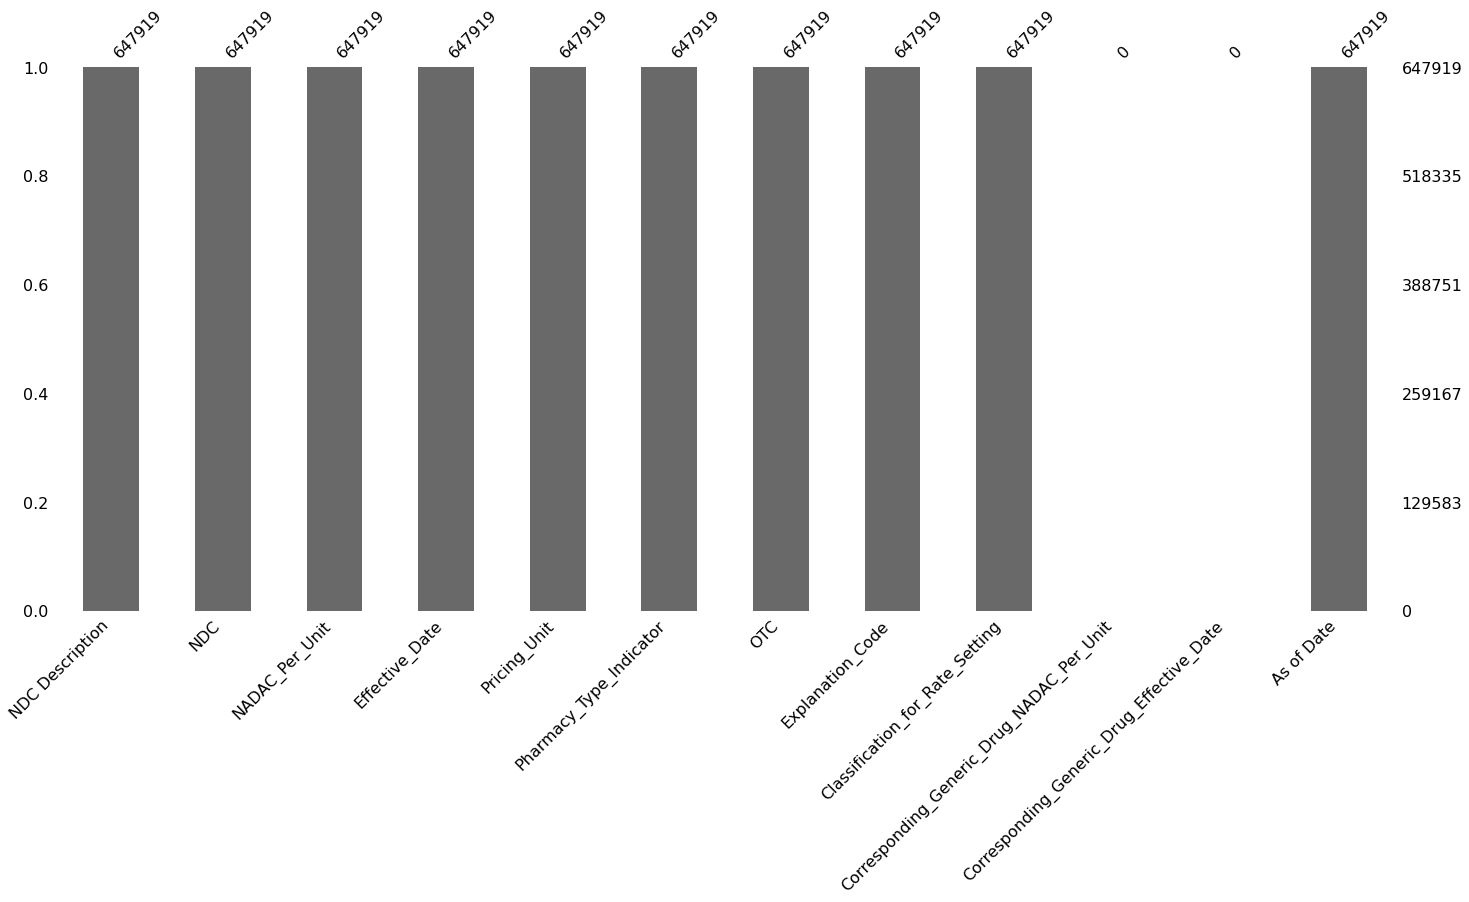

In [524]:
msno.bar(nadac_generics_df_orig);

#### Tried to auto find features using AutoFeatRegressor from autofeat library
- This fails, needs to explore alternatives

In [525]:
# Auto Feature detection using AutoFeatRegressor
# null_columns = nadac_generics_df.columns[nadac_generics_df.isnull().any()]
# explore_df = nadac_generics_df.copy().drop(columns = null_columns)
# X = explore_df.drop('NADAC_Per_Unit', axis = 1)
# y = explore_df['NADAC_Per_Unit']

# cat_cols = explore_df.select_dtypes(exclude=np.number).columns.to_list()
# autoFeatmodel = AutoFeatRegressor(categorical_cols = cat_cols)
# df = autoFeatmodel.fit_transform(X, y)
# pred = model.predict(X_test)
# print("Final R^2: %.4f" % model.score(df, y))

### Data Preparation
- Drop NAN columns and unrelated columns to dependent variable NADAC_Per_Unit
- Transform using Label Encoder (ONE HOT ENCODER creates many columns)

In [526]:
# Dropping unrelated columns 
cols_to_drop = ['NDC','OTC','Corresponding_Generic_Drug_NADAC_Per_Unit',
                'Corresponding_Generic_Drug_Effective_Date', 'As of Date',
               'Pharmacy_Type_Indicator','Classification_for_Rate_Setting']

nadac_generics_df = nadac_generics_df_orig.drop(columns = cols_to_drop)
before = nadac_generics_df.shape
nadac_generics_df = nadac_generics_df.drop_duplicates()
after = nadac_generics_df.shape
print('Dropped Duplicate Counts:' , before[0]-after[0], ',Resulting DataFrame shape:', nadac_generics_df.shape)
nadac_generics_df.isna().sum()

Dropped Duplicate Counts: 622001 ,Resulting DataFrame shape: (25918, 5)


NDC Description     0
NADAC_Per_Unit      0
Effective_Date      0
Pricing_Unit        0
Explanation_Code    0
dtype: int64

In [527]:
# Label encoder & decoder functions 
encoders = []
def label_encode(cat_columns, df_enc):
    for c in cat_columns:
        le = LabelEncoder()
        encoders.append( le.fit(list(df_enc[c].astype(str).values)))
        df_enc[c] = le.transform(list(df_enc[c].astype(str).values))
            
def label_decode(df_enc):
    output = df_enc.copy()
    for col in cat_columns:
        output[col] = encoders[cat_columns.index(col)].inverse_transform(df_enc[col])
    return output

In [528]:
cat_columns = nadac_generics_df.select_dtypes(exclude=np.number).columns.to_list()
print(f'Categorical columns: {cat_columns}\n\n')
nadac_generics_df_enc = nadac_generics_df.copy()
label_encode(cat_columns,nadac_generics_df_enc)
nadac_generics_df_enc.sample(10)
# Target Encoder & James Stin

Categorical columns: ['NDC Description', 'Effective_Date', 'Pricing_Unit', 'Explanation_Code']




,NDC Description,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Explanation_Code
198555,2461,0.19584,9,0,0
176793,230,0.45261,9,0,0
375698,165,0.90176,22,0,3
9850,1026,0.21031,2,0,0
294865,2104,0.35091,16,0,0
707945,732,1.33732,37,0,8
34921,1038,0.08556,66,0,3
175303,103,4.02680,9,0,3
719820,1917,3.83226,45,1,2
278742,438,0.10947,16,1,1


In [529]:
#Variance Infation Factor
vif_data = pd.DataFrame()
vif_data["feature"] = nadac_generics_df_enc.columns 

vif_data["VIF"] = [variance_inflation_factor(nadac_generics_df_enc.values, i)
                          for i in range(len(nadac_generics_df_enc.columns))]
  
print(vif_data)

            feature       VIF
0   NDC Description  2.094334
1    NADAC_Per_Unit  1.070957
2    Effective_Date  2.176511
3      Pricing_Unit  1.299081
4  Explanation_Code  1.367997


In [530]:
from scipy.stats import pearsonr
def calculate_pvalues(df):
    df      = df._get_numeric_data()
    dfcols  = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if c == r:
                df_corr = df[[r]].dropna()
            else:
                df_corr = df[[r,c]].dropna()
            pvalues[r][c] = pearsonr(df_corr[r], df_corr[c])[1]
    return pvalues

,NDC Description,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Explanation_Code
NDC Description,0.0,0.0,0.940805,0.0,0.000001
NADAC_Per_Unit,0.0,0.0,0.161611,0.0,0.0
Effective_Date,0.940805,0.161611,0.0,0.901486,0.0
Pricing_Unit,0.0,0.0,0.901486,0.0,0.0
Explanation_Code,0.000001,0.0,0.0,0.0,0.0


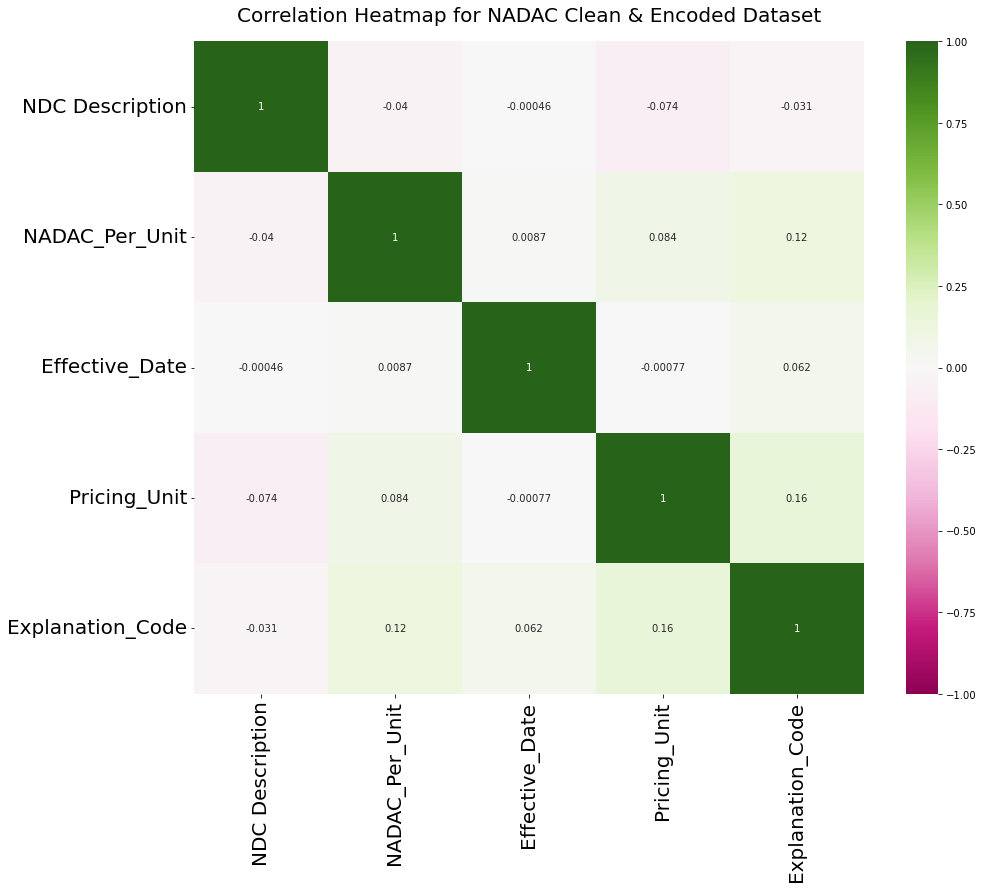

In [531]:
# Correlation Analysis
f, ax = plt.subplots(figsize=(15, 12))
ax.set_title('Correlation Heatmap for NADAC Clean & Encoded Dataset', pad=20,fontsize = 20)
g = sns.heatmap(nadac_generics_df_enc.corr(), vmin=-1, vmax=1, annot=True, cmap='PiYG')
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 20)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20);
# show p-values
calculate_pvalues(nadac_generics_df_enc)
# Mutual Information Gain, Regressor

**Observation**: Even though NDC Description has negative coorelation with other features, it is important, so I am keeping it. 

<AxesSubplot:xlabel='NADAC_Per_Unit', ylabel='Density'>

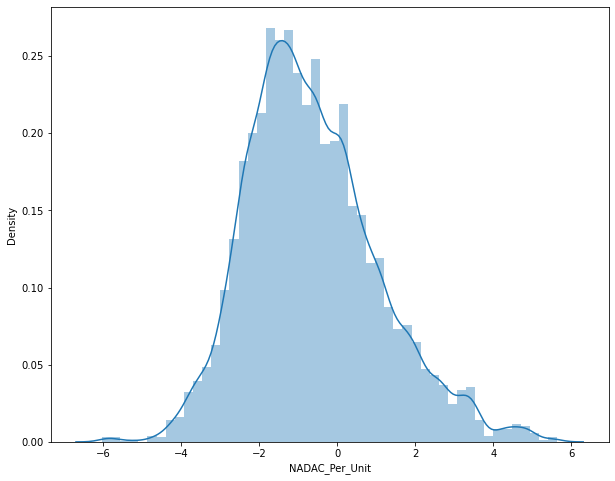

In [532]:
sns.distplot(np.log(nadac_generics_df_enc['NADAC_Per_Unit']))


<AxesSubplot:xlabel='NDC Description', ylabel='Density'>

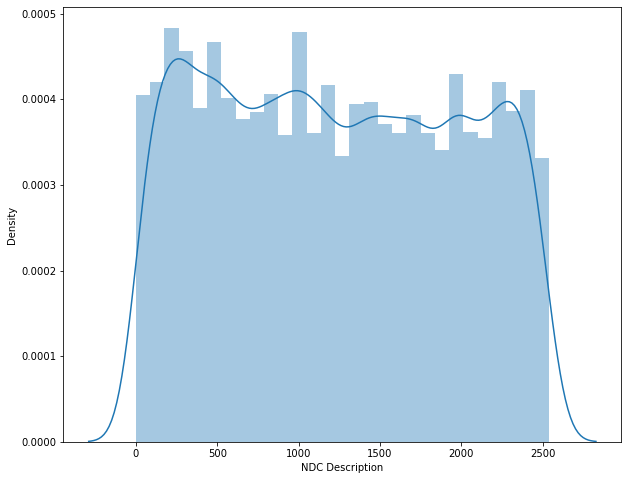

In [533]:
sns.distplot(nadac_generics_df_enc['NDC Description'])


<Figure size 2160x576 with 0 Axes>

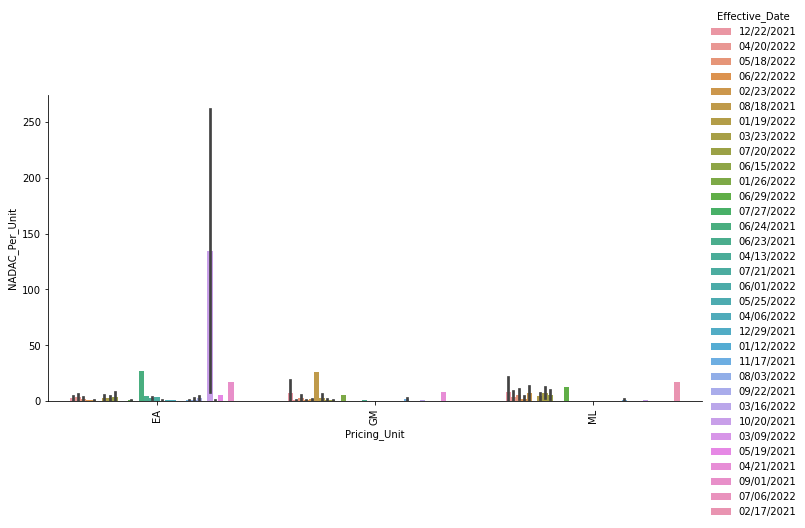

In [534]:
plt.figure(figsize=(30,8))
g = sns.catplot(x='Pricing_Unit', y ='NADAC_Per_Unit', hue='Effective_Date', data=nadac_generics_df.sample(1000), 
            kind="bar", aspect=2, height=5)
g.set_xticklabels(rotation=90);


### Modeling
 - Linear Regression Lasso and Ridge models produced low accuracy scores 
 - Found RandomForestRegressor to be the best fit 

In [535]:
X = nadac_generics_df_enc.drop(columns = ['NADAC_Per_Unit'], axis = 1)
y = nadac_generics_df_enc['NADAC_Per_Unit']

#Sequencial Feature Selection
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr,n_features_to_select=3)
sfs.fit(X.copy(), y)
print('SFS selected Columns: ', X.columns[sfs.get_support()].values)


#  Column Importance
lr.fit(X,y)
r = permutation_importance(lr, X, y, n_repeats = 50, random_state = 42)

per_imp_df = pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)
print('Permutation Importance: ')
per_imp_df


SFS selected Columns:  ['NDC Description' 'Pricing_Unit' 'Explanation_Code']
Permutation Importance: 


,Column,Importance
3,Explanation_Code,0.023781
2,Pricing_Unit,0.008349
0,NDC Description,0.002029
1,Effective_Date,0.000007


In [536]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=42)

In [537]:
lr_model     = LinearRegression().fit(X_train,y_train)
lr_y_pred    = lr_model.predict(X_test)
lr_train_s   = round(lr_model.score(X_train, y_train)*100, 2)
lr_test_s    = round(lr_model.score(X_test, y_test)*100, 2)
print('Default Linear Regression Model Scores:', lr_train_s, lr_test_s)

Default Linear Regression Model Scores: 1.86 2.22


In [538]:
lasso_model     = Lasso().fit(X_train,y_train)
lasso_y_pre     = lasso_model.predict(X_test)
lasso_train_acc = round(lasso_model.score(X_train, y_train)*100, 2)
lasso_test_acc  = round(lasso_model.score(X_test, y_test)*100, 2)
print('Default Lasso Model Scores:' ,lasso_train_acc, lasso_test_acc)
lasso_params    = {'alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
lasso_grid      = GridSearchCV(lasso_model, param_grid = lasso_params).fit(X_train,y_train)
lasso_grid.best_estimator_
lasso_train_acc = round(lasso_grid.score(X_train, y_train)*100, 2)
lasso_test_acc  = round(lasso_grid.score(X_test, y_test)*100, 2)
print('Grid search Lasso Model Scores:' ,lasso_train_acc, lasso_test_acc)


Default Lasso Model Scores: 0.83 0.97
Grid search Lasso Model Scores: 1.86 2.22


In [539]:
ridge_model     = Ridge().fit(X_train,y_train)
ridge_y_pre     = ridge_model.predict(X_test)
ridge_train_acc = round(ridge_model.score(X_train, y_train)*100, 2)
ridge_test_acc  = round(ridge_model.score(X_test, y_test)*100, 2)
print('Default Ridge Model Scores:' ,ridge_train_acc, ridge_test_acc)
ridge_params    = {'fit__alpha':[550, 580, 600, 620, 650]}
ridge_grid      = GridSearchCV(ridge_model, param_grid = lasso_params).fit(X_train,y_train)
ridge_grid.best_estimator_
ridge_train_acc = round(ridge_grid.score(X_train, y_train)*100, 2)
lasso_test_acc  = round(ridge_grid.score(X_test, y_test)*100, 2)
print('Grid search Ridge Model Scores:' ,ridge_train_acc, ridge_test_acc)


Default Ridge Model Scores: 1.86 2.22
Grid search Ridge Model Scores: 1.86 2.22


In [540]:
rf_model  = RandomForestRegressor().fit(X_train,y_train)
y_pred    = rf_model.predict(X_test)
train_acc = round(rf_model.score(X_train, y_train)*100, 2)
test_acc  = round(rf_model.score(X_test, y_test)*100, 2)
print('Train Score: ',train_acc,' Test Score: ', test_acc)


Train Score:  99.45  Test Score:  87.68


In [541]:
scores = cross_val_score(rf_model, X, y, cv=5,scoring='r2')
print(scores.mean(), scores.std())

0.9195167534992779 0.07116491733837972


### Evaluation

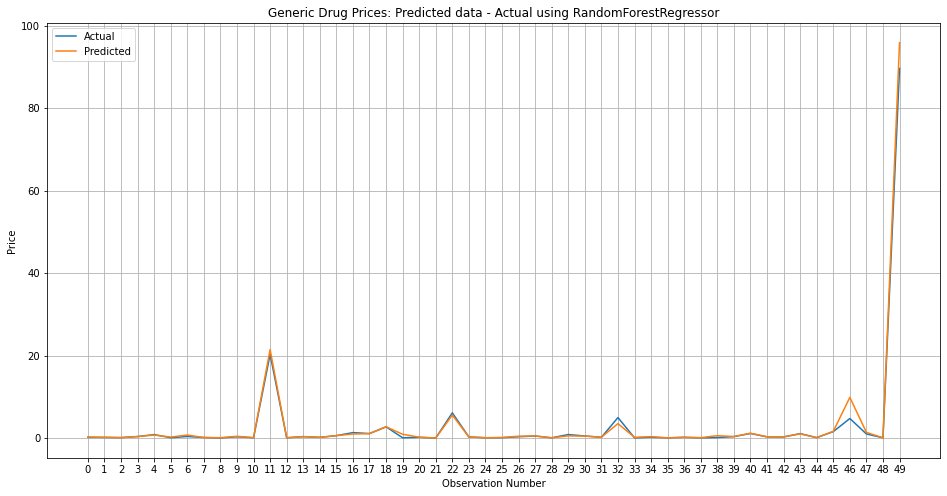

In [542]:
number_of_observations=50
x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(16,8))
plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title('Generic Drug Prices: Predicted data - Actual using RandomForestRegressor')
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show();

#### Evaluating by using sklearn.metrics

In [543]:
metric_mse       = mean_squared_error(y_test, y_pred )
metric_max_error = max_error(y_test, y_pred )
metric_r2_score  = r2_score(y_test,y_pred )
metric_mbe       = np.mean(y_pred - y_test)
print('Mean Squared Error:',round(metric_mse,2))
print('Max Error:',round(metric_max_error,2))
print('r2_score :',round(metric_r2_score,2))
print('Mean Bias Error :', round(metric_mbe,2))


Mean Squared Error: 25.27
Max Error: 277.77
r2_score : 0.88
Mean Bias Error : -0.11


In [544]:
random_grid_params = { 'bootstrap': [True, False],
                       'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                       'min_samples_leaf': [1, 2, 4],
                       'min_samples_split': [2, 5, 10],
                       'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

random_grid = RandomizedSearchCV(rf_model, param_distributions = random_grid_params,
                                 n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1).fit(X_train,y_train)
grid_score = random_grid.score(X_test,y_test)
print('Grid Score:', grid_score)
print('Grid Best Params: ', random_grid.best_params_)
print('Grid Best Score: ', random_grid.best_score_)
print('Grid Best Estimator: ', random_grid.best_estimator_)
print('Grid Error Score: ', random_grid.error_score)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0.8785418961892444
{'mean_fit_time': array([48.51760141, 19.74072393,  7.35366535, 10.5785977 ,  5.479309  ,
       20.82667685, 21.4967769 , 18.86711367, 24.51780033, 27.49797773,
       40.81144738, 14.16877564, 52.6552852 , 28.96722881, 26.07551734,
       42.18248916, 46.78781962, 41.34469159, 17.93881591, 12.23737391,
       10.69114073, 12.52960253, 45.86091932,  9.90915569,  5.958728  ,
       20.01974646, 35.58216198, 41.85220234, 47.77616771,  6.50548434,
        8.60625331, 16.18634009, 30.3574837 , 66.61498276,  7.59922266,
       27.39143626,  3.55544074, 41.88217958, 26.19865894,  2.63816476,
       36.3237048 , 41.12565398, 15.30959892, 11.57765134,  5.9306767 ,
       28.91831374, 15.04007363, 29.76106326,  7.12782685, 33.30360897,
        5.28754528, 35.9312319 , 11.65726328, 28.70100395, 12.41439271,
       40.20504308, 32.3405757 , 57.73488959, 53.69546572, 45.24248584,
       17.79444305, 35.375542  , 29.

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  54.0s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   7.7s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  11.1s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  21.7s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  23.0s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  25.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  28.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  14.8s
[CV] END bootstrap=False, max_depth=10, min_samples_l

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  54.1s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   7.7s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  11.0s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.8s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  22.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  20.0s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  25.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time=  42.9s
[CV] END bootstrap=False, max_depth=10, min_samples_

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=  54.1s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   7.8s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  21.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  19.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  19.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=  28.7s
[CV] END bootstrap=False, max_depth=20, min_sample

In [546]:
print(random_grid.best_params_)
print(random_grid.best_score_)
print(random_grid.best_estimator_)
best_estimator = random_grid.best_estimator_

{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}
0.9457196290233564
RandomForestRegressor(bootstrap=False, max_depth=50, n_estimators=600)


In [563]:
y_pred_grid    = best_estimator.predict(X_test)

In [565]:
errors = abs(y_pred_grid - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
Average Error: 0.5044 degrees.
Accuracy = 56.23%.


In [564]:
grid_metric_mse       = mean_squared_error(y_test, y_pred_grid )
grid_metric_max_error = max_error(y_test, y_pred_grid )
grid_metric_r2_score  = r2_score(y_test,y_pred_grid )
grid_metric_mbe       = np.mean(y_pred_grid - y_test)
print('Mean Squared Error:',round(grid_metric_mse,2))
print('Max Error:',round(grid_metric_max_error,2))
print('r2_score :',round(grid_metric_r2_score,2))
print('Mean Bias Error :', round(grid_metric_mbe,2))

Mean Squared Error: 24.9
Max Error: 278.03
r2_score : 0.88
Mean Bias Error : -0.09


In [ ]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(best_estimator.estimators_[0],X_train, y_train,
              feature_names = nadac_generics_df_enc.columns,
              title = 'Best decision tree')
viz.save("images/dtree_drug_prices.svg")


### Predicting

In [547]:
def predict_price(sample_df):
    """ Function takes in a sample dataframe from the clean dataset, 
    and transforms the feature columns 
    and ouputs the the predicted price array:"""

    x     = np.zeros(4)
    x[0]  = encoders[cat_columns.index('NDC Description')].transform([sample_df['NDC Description'].values[0]])
    x[1]  = encoders[cat_columns.index('Effective_Date')].transform([sample_df['Effective_Date'].values[0]])  
    x[2]  = encoders[cat_columns.index('Pricing_Unit')].transform([sample_df['Pricing_Unit'].values[0]])
    x[3]  = encoders[cat_columns.index('Explanation_Code')].transform([sample_df['Explanation_Code'].values[0]])

    x = scaler.transform([x])
    predicted_price = best_estimator.predict(x)

    return predicted_price

In [548]:
def get_predictions_dict(sample_df, predicted_price):
    
    results = []
    ndc = nadac_df.iloc[sample_df.index]['NDC'].values[0]
    mddb_prices_df = mddb_df[['WAC','AWP']][mddb_df['NDC'] == ndc]
    wac       = 'No Data'
    awp       = 'No Data'
    wpp       = 'No Data'
    eff_date  =  nadac_df.iloc[sample_df.index]['Effective_Date'].values[0]
    if not mddb_prices_df.empty:
        wac   = round(mddb_prices_df['WAC'].values[0], 2)
        awp   = round(mddb_prices_df['AWP'].values[0], 2)
        wpp   = str(round(np.abs((awp-wac) * 100/wac), 2)) + '%'
    
    results.append({'NDC':ndc,
                       'Actual_Invoice_Price': round(sample_df['NADAC_Per_Unit'].values[0],2),
                       'Predicted_Invoice_Price':round(predicted_price[0], 2),
                       'Wholesaler_Aquisition_Cost' : wac,
                       'Average_Wholesale_Price'    : awp,
                       'Wholesaler_Gross_Profit'    : wpp,
                       'Effective_Date'             : eff_date
                  })
    
    return results

In [549]:
results_df = pd.DataFrame( columns=['NDC', 'Actual_Invoice_Price',
                                    'Predicted_Invoice_Price','Wholesaler_Aquisition_Cost',
                                    'Average_Wholesale_Price', 'Wholesaler_Gross_Profit',
                                    'Effective_Date'])

for i in range(1,10):
    sample_df       = nadac_generics_df.sample(1)
    predicted_price = predict_price(sample_df)   
    results         = get_predictions_dict(sample_df,predicted_price)
    df_dictionary   = pd.DataFrame.from_dict(results)
    results_df      = pd.concat([results_df, df_dictionary])
    results_df.reset_index()

results_df


,NDC,Actual_Invoice_Price,Predicted_Invoice_Price,Wholesaler_Aquisition_Cost,Average_Wholesale_Price,Wholesaler_Gross_Profit,Effective_Date
0,16714006701,1.43,1.43,8.84,16.54,87.1%,02/23/2022
0,115143808,0.19,0.19,1.21,6.05,400.0%,07/20/2022
0,68382039801,0.28,0.24,0.50,0.63,26.0%,07/20/2022
0,93416076,0.03,0.03,0.07,0.09,28.57%,11/17/2021
0,228253810,0.14,0.14,0.26,0.77,196.15%,05/18/2022
0,574985510,0.99,0.99,2.23,2.67,19.73%,01/19/2022
0,51672401701,0.37,0.42,1.29,1.62,25.58%,07/20/2022
0,93943301,0.09,0.09,0.21,0.46,119.05%,04/20/2022
0,93915701,0.10,0.10,0.35,2.18,522.86%,04/20/2022


In [550]:
def predict_by_gppc(gppc):
    results_df = pd.DataFrame( columns=['NDC', 'Actual_Invoice_Price',
                                    'Predicted_Invoice_Price','Wholesaler_Aquisition_Cost',
                                    'Average_Wholesale_Price', 'Wholesaler_Gross_Profit',
                                    'Effective_Date'])
    gppc_df       = mddb_df.query("GPPC ==@gppc")
    gppc_ndcs     = gppc_df['NDC'].values
    to_predict_df = nadac_df[nadac_df['NDC'].isin(gppc_ndcs)]
    for index in to_predict_df.index:
        try:
            sample_df       = nadac_df.iloc[[index]]
            predicted_price = predict_price(sample_df)
            results         = get_predictions_dict(sample_df,predicted_price)
            df_dictionary   = pd.DataFrame.from_dict(results)
            results_df      = pd.concat([results_df, df_dictionary])
        except:
            pass
    
    return results_df


In [551]:
gppc_results_df = predict_by_gppc('26341966')
gppc_results_df


,NDC,Actual_Invoice_Price,Predicted_Invoice_Price,Wholesaler_Aquisition_Cost,Average_Wholesale_Price,Wholesaler_Gross_Profit,Effective_Date
0,13668010790,0.24,0.24,1.00,10.19,919.0%,01/19/2022
0,62175030246,0.24,0.24,0.46,11.45,2389.13%,01/19/2022
0,65862072190,0.24,0.24,0.33,11.46,3372.73%,01/19/2022
0,67877044390,0.24,0.24,0.27,11.46,4144.44%,01/19/2022
0,68180022009,0.24,0.24,2.29,11.46,400.44%,01/19/2022
...,...,...,...,...,...,...,...
0,13668010790,0.24,0.24,1.00,10.19,919.0%,07/20/2022
0,62175030246,0.24,0.24,0.46,11.45,2389.13%,07/20/2022
0,65862072190,0.24,0.24,0.33,11.46,3372.73%,07/20/2022
0,67877044390,0.24,0.24,0.27,11.46,4144.44%,07/20/2022


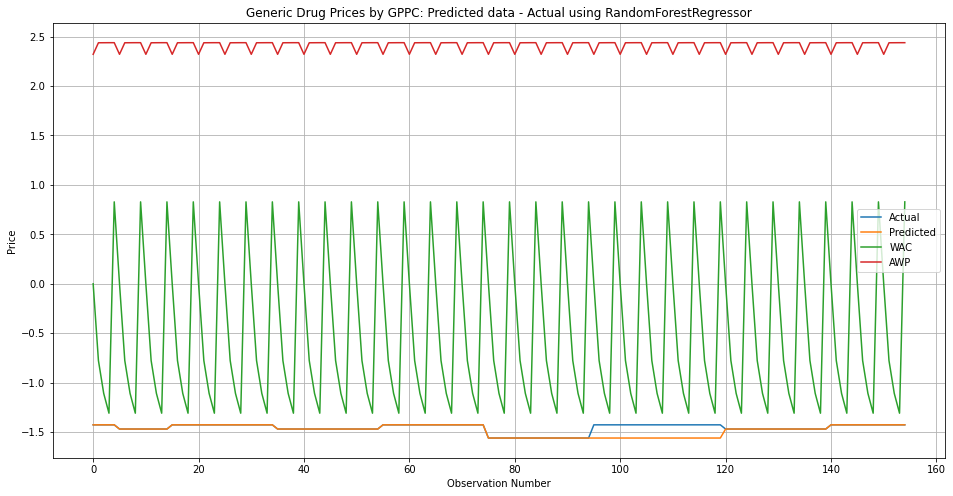

In [552]:
number_of_observations=gppc_results_df.shape[0]
x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(16,8))
plt.plot(x_ax, np.log(gppc_results_df['Actual_Invoice_Price']), label="Actual")
plt.plot(x_ax, np.log(gppc_results_df['Predicted_Invoice_Price']), label="Predicted")
plt.plot(x_ax, np.log(gppc_results_df['Wholesaler_Aquisition_Cost']), label="WAC")
plt.plot(x_ax, np.log(gppc_results_df['Average_Wholesale_Price']), label="AWP")
plt.title('Generic Drug Prices by GPPC: Predicted data - Actual using RandomForestRegressor')
plt.xlabel('Observation Number')
plt.ylabel('Price')
# plt.xticks(np.arange(np.log(number_of_observations)))
# plt.xticks(rotation = 90) 
plt.legend()
plt.grid()
plt.show();


In [553]:
def predict_by_gpid(gpid):
    results_df = pd.DataFrame( columns=['NDC', 'Actual_Invoice_Price',
                                    'Predicted_Invoice_Price','Wholesaler_Aquisition_Cost',
                                    'Average_Wholesale_Price', 'Wholesaler_Gross_Profit',
                                    'Effective_Date'])
    gpid_df       = mddb_df.query("GPID == @gpid")
    gpid_ndcs     = gpid_df['NDC'].values
    to_predict_df = nadac_df[nadac_df['NDC'].isin(gpid_ndcs)]
    for index in to_predict_df.index:
        try:
            sample_df       = nadac_df.iloc[[index]]
            predicted_price = predict_price(sample_df)
            results         = get_predictions_dict(sample_df,predicted_price)
            df_dictionary   = pd.DataFrame.from_dict(results)
            results_df      = pd.concat([results_df, df_dictionary])
        except:
            pass
        
    return results_df


In [554]:
gpid_results_df = predict_by_gpid('49270076100620')
gpid_results_df


,NDC,Actual_Invoice_Price,Predicted_Invoice_Price,Wholesaler_Aquisition_Cost,Average_Wholesale_Price,Wholesaler_Gross_Profit,Effective_Date
0,13668010705,0.24,0.24,1.00,10.19,919.0%,01/19/2022
0,13668010730,0.24,0.24,1.00,10.19,919.0%,01/19/2022
0,13668010790,0.24,0.24,1.00,10.19,919.0%,01/19/2022
0,62175030232,0.24,0.24,0.47,11.45,2336.17%,01/19/2022
0,62175030243,0.24,0.24,0.44,11.45,2502.27%,01/19/2022
...,...,...,...,...,...,...,...
0,65862072190,0.24,0.24,0.33,11.46,3372.73%,07/20/2022
0,67877044330,0.24,0.24,0.30,11.44,3713.33%,07/20/2022
0,67877044390,0.24,0.24,0.27,11.46,4144.44%,07/20/2022
0,68180022006,0.24,0.24,2.29,11.46,400.44%,07/20/2022


### Time Series Analysis

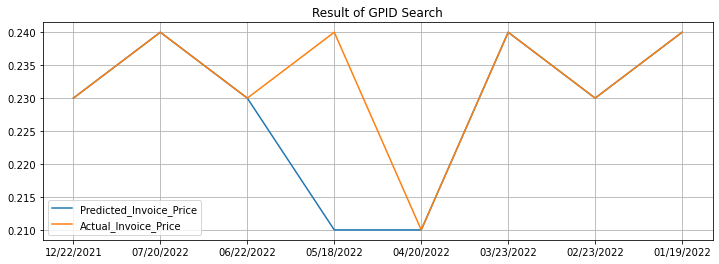

In [555]:
gpid_results_df = gpid_results_df.sort_values(by=['Effective_Date'], ascending = False)
plt.figure(figsize = (12, 4))
plt.plot(gpid_results_df['Effective_Date'], gpid_results_df['Predicted_Invoice_Price'], label = 'Predicted_Invoice_Price')
plt.plot(gpid_results_df['Effective_Date'],gpid_results_df['Actual_Invoice_Price'], label = 'Actual_Invoice_Price')
plt.legend()
plt.grid()
plt.title('Result of GPID Search');


In [556]:
nadac_df['Effective_Date'].unique()

array(['12/22/2021', '12/15/2021', '11/17/2021', '04/21/2021',
       '10/20/2021', '04/01/2021', '01/19/2022', '01/15/2022',
       '08/18/2021', '02/02/2022', '01/12/2022', '05/19/2021',
       '07/21/2021', '08/04/2021', '09/22/2021', '10/02/2021',
       '01/01/2022', '06/23/2021', '01/26/2022', '04/07/2021',
       '02/17/2021', '03/17/2021', '01/14/2022', '01/03/2022',
       '01/10/2022', '04/02/2021', '10/01/2021', '12/30/2021',
       '11/03/2021', '01/06/2022', '12/29/2021', '02/01/2022',
       '10/27/2021', '07/14/2021', '03/03/2021', '01/05/2022',
       '10/13/2021', '02/09/2022', '11/10/2021', '10/30/2021',
       '07/01/2021', '01/11/2022', '12/17/2021', '06/16/2021',
       '07/28/2021', '09/15/2021', '08/01/2021', '09/01/2021',
       '01/20/2022', '09/29/2021', '08/11/2021', '06/24/2021',
       '06/01/2021', '10/14/2021', '10/06/2021', '02/24/2021',
       '05/26/2021', '01/17/2022', '12/09/2021', '01/25/2022',
       '10/08/2021', '10/19/2021', '09/08/2021', '08/12

In [557]:
def get_timeseries_df_by_group(group,group_id):
    if(group == 'GPID'):
        df       = mddb_df.query("GPID == @group_id")
    else:
        df       = mddb_df.query("GPPC == @group_id")
    
    if(df.empty):
        return None
        
    gpid_ndcs     = df['NDC'].values
    to_predict_df = nadac_df[nadac_df['NDC'].isin(gpid_ndcs)]
    timeseries_df = to_predict_df[['NADAC_Per_Unit','Effective_Date']]
    timeseries_df['Effective_Date'] = pd.to_datetime(timeseries_df['Effective_Date'],format='%m/%d/%Y')
    timeseries_df = timeseries_df.set_index(pd.DatetimeIndex(timeseries_df['Effective_Date'])).drop(columns=['Effective_Date'])
    timeseries_df.sort_index(inplace=True)


    return timeseries_df

In [558]:
def plot_auto_correlation(timeseries_df):
    y_hist, y_future = train_test_split(timeseries_df, shuffle=False)
    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    plot_acf(y_hist, ax = ax[0]);
    ax[0].grid()
    plot_pacf(y_hist, ax = ax[1], method = 'ywm');
    ax[1].grid()

In [559]:
def plot_seasonal_decomposition(timeseries_df):
    #   Plot Seasonal Decomposition  
    decomposed = seasonal_decompose(timeseries_df['NADAC_Per_Unit'],period = 2)
    plt.rcParams['figure.figsize'] = (10, 8)
    x = decomposed.plot()
    plt.plot(decomposed.resid)
    plt.grid();

In [560]:
def model_forecast_timeseries(timeseries_df):

    if(adfuller(timeseries_df['NADAC_Per_Unit'])[1] <= 0.5):
        y_hist, y_future = train_test_split(timeseries_df, shuffle=False)
        arma             = ARIMA(y_hist['NADAC_Per_Unit'], order = (1, 0, 16)).fit()
#         print(arma.summary())
        hist_preds       = arma.predict()
        future_preds     = arma.forecast(steps = len(y_future)).set_axis(y_future.index)
       
        avg_hist_price   = np.mean(hist_preds)
        avg_future_price = np.mean(future_preds)

        print('Historical average invoice price: ', avg_hist_price,2)
        print('Future average invoice price: ', avg_future_price)
        plt.figure(figsize = (12, 4))
        plt.plot(hist_preds, label = 'model')
        plt.plot(y_hist, label = 'data')
        plt.plot(future_preds, label = 'future')
        plt.legend()
        plt.grid()
        plt.title('Result of ARMA Model');
        plt.show();
        
       
        mse_test = mean_squared_error(future_preds, y_future)
        print('Mean Squared Error', round(mse_test,2))
        
        

                NADAC_Per_Unit
Effective_Date                
2021-10-02            18.26883
2021-10-02            18.26883
2021-10-02            18.26883
2021-10-02            18.26883
2021-10-02            18.26883
...                        ...
2022-07-20             0.23590
2022-07-20             0.23590
2022-07-20             0.23590
2022-07-20             0.23590
2022-07-20             0.23590

[408 rows x 1 columns]
Historical average invoice price:  2.068034068072786 2
Future average invoice price:  0.23741077821542653


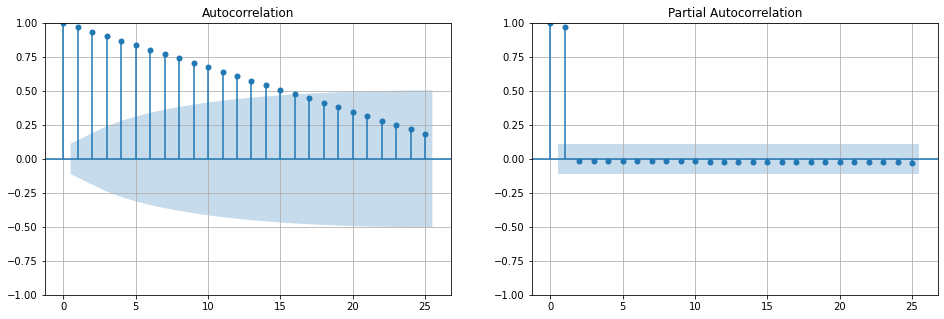

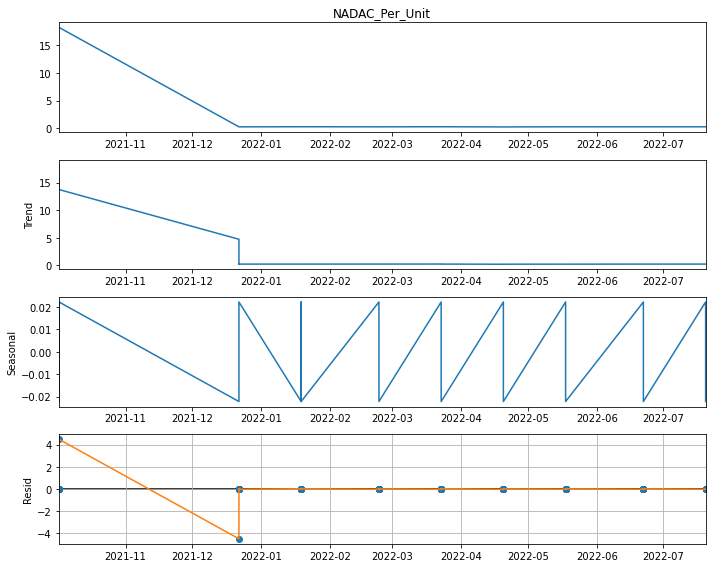

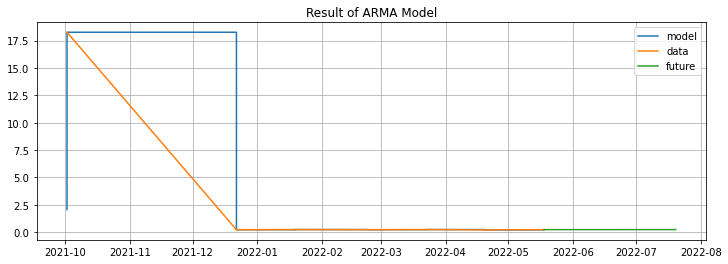

Mean Squared Error 0.0


In [561]:
timeseries_df = get_timeseries_df_by_group('GPID','49270076100620')
print(timeseries_df)
plot_auto_correlation(timeseries_df)
plot_seasonal_decomposition(timeseries_df)
model_forecast_timeseries(timeseries_df)

### TODO : Other Ideas
- Seek alternatives for auto feature selection
- Create a python class and bring in all capstone methods into it
- Work on NDC description splitting it using NLP and introduce new columns for regression
- Integrate this model with Rasa 
    - To create chat bot that recommends medication when illness is entered
    - Consider Therapuetic categories for classification


In [243]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [244]:
temp_df = nadac_df.sample(10)
temp_df['NDC_Desc2'] = temp_df['NDC Description'].apply(lambda x: nlp(x))
temp_df[['NDC Description','NDC_Desc2']]

,NDC Description,NDC_Desc2
406869,DULOXETINE HCL DR 30 MG CAP,"(DULOXETINE, HCL, DR, 30, MG, CAP)"
79645,CIPROFLOXACIN HCL 750 MG TAB,"(CIPROFLOXACIN, HCL, 750, MG, TAB)"
274483,ALL DAY PAIN RELIEF 220 MG TAB,"(ALL, DAY, PAIN, RELIEF, 220, MG, TAB)"
98576,VALACYCLOVIR HCL 1 GRAM TABLET,"(VALACYCLOVIR, HCL, 1, GRAM, TABLET)"
699613,TROSPIUM CHLORIDE ER 60 MG CAP,"(TROSPIUM, CHLORIDE, ER, 60, MG, CAP)"
606945,DIPYRIDAMOLE 25 MG TABLET,"(DIPYRIDAMOLE, 25, MG, TABLET)"
33699,FAMOTIDINE 20 MG TABLET,"(FAMOTIDINE, 20, MG, TABLET)"
195293,ROSUVASTATIN CALCIUM 5 MG TAB,"(ROSUVASTATIN, CALCIUM, 5, MG, TAB)"
413560,MELOXICAM 15 MG TABLET,"(MELOXICAM, 15, MG, TABLET)"
2681,BENZONATATE 100 MG CAPSULE,"(BENZONATATE, 100, MG, CAPSULE)"
